# Part 3 : CIFAR classification in Fully Homomorphic Encryption (FHE)

In this last notebook, we show how to evaluate a quantized models using FHE simulation, allowing users to quickly mimic what would occur when converting a model to FHE without bit-width restrictions and without actually performing the FHE calculations.

## Import the required packages

In [1]:
import warnings

import torch
from cifar_utils import (
    fhe_compatibility,
    fhe_simulation_inference,
    get_dataloader,
    plot_dataset,
    torch_inference,
)
from models import QuantVGG11
from torchvision import datasets

warnings.filterwarnings("ignore", category=UserWarning)

## Settings

In [2]:
bit = 5
seed = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device Type: {device}")

Device Type: cpu


## 1. CIFAR-10 with FHE simulation

In [3]:
param_c10 = {
    "output_size": 10,
    "batch_size": 128,
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "std": [0.247, 0.243, 0.261],
    "mean": [0.4914, 0.4822, 0.4465],
    "dir": "./checkpoints/CIFAR_10",
    "pre_trained_path": "quant/CIFAR_10_quant_state_dict.pt",
    "seed": 42,
}

### Data-set

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


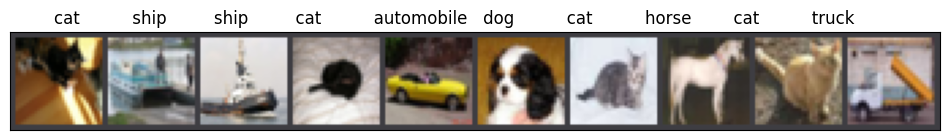

In [4]:
# Load CIFAR-10 data-set.
train_loader_c10, test_loader_c10 = get_dataloader(param=param_c10)

# Let’s visualize `n` images from CIFAR-10 data-set.
plot_dataset(test_loader_c10, param_c10)

### Quantized FHE-friendly network

In [5]:
# Loading the pre-trained quantized model.
quant_vgg_c10 = QuantVGG11(bit=bit, output_size=param_c10["output_size"])

checkpoint = torch.load(f"{param_c10['dir']}/{param_c10['pre_trained_path']}", map_location=device)

quant_vgg_c10.load_state_dict(checkpoint)

<All keys matched successfully>

### FHE simulation 

The FHE simulation is faster than the actual FHE compilation, because it relies only on Python, it doesn't perform any crypto operations or keys generation. It's a useful simulation environment that :
- checks if the homomorphic inference is possible, depending on the chosen parameters
- determines the bit-width precision required in the circuit based on the given input and model's weights/activations
- is independent of the actual bit precision limitation 
- provides a quantized module, that allows users to evaluate the model without FHE operations and the resulting accuracy should be equal to the real FHE execution


To use this FHE simulation, the user needs to provide an exhaustive set of data in order to determine the maximum bit-width within the circuit.

In [6]:
# The user can either provide the entire train data-set or a smaller but representative subset.
# As each batch is shuffled and contains 128 samples, it's a potential subset.

data_calibration, _ = next(iter(train_loader_c10))

qmodel_c10 = fhe_compatibility(quant_vgg_c10, data_calibration)

print(
    f"Maximum bit-width in the circuit: {qmodel_c10.fhe_circuit.graph.maximum_integer_bit_width()}"
)

Maximum bit-width in the circuit: 14


In [7]:
# Evaluation with the FHE simulation for CIFAR-10.
acc_fhe_c10 = fhe_simulation_inference(qmodel_c10, test_loader_c10, True)

100%|██████████| 78/78 [48:57<00:00, 37.66s/it]


In [8]:
# Evaluation with Brevitas torch for CIFAR-10.
acc_torch_c10 = torch_inference(quant_vgg_c10, test_loader_c10, device=device)

In [9]:
print(f"Top-1 acc in Brevitas torch: {acc_torch_c10 * 100 :2.2f}%")
print(f"Top-1 acc with Concrete ML : {acc_fhe_c10 * 100 :2.2f}%")

Top-1 acc in Brevitas torch: 83.80%
Top-1 acc with Concrete ML : 82.98%


## 2. CIFAR-100 with FHE simulation

Since the methodology is the same, we do exactly the same thing but this time with the CIFAR-100 hyper-parameters.

In [10]:
param_c100 = {
    "output_size": 100,
    "batch_size": 128,
    "dataset_name": "CIFAR_100",
    "dataset": datasets.CIFAR100,
    "std": [0.229, 0.224, 0.225],
    "mean": [0.485, 0.456, 0.406],
    "dir": "./checkpoints/CIFAR_100",
    "pre_trained_path": "quant/CIFAR_100_quant_state_dict.pt",
    "seed": 42,
}

### Data-set

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


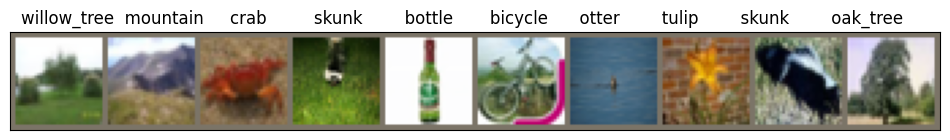

In [11]:
# Load CIFAR-100 data-set.
train_loader_c100, test_loader_c100 = get_dataloader(param=param_c100)

# Let’s visualize `n` images from CIFAR-100 data-set.
plot_dataset(test_loader_c100, param_c100)

### Quantized FHE-friendly network

In [12]:
# Loading the pre-trained quantized model.
quant_vgg_c100 = QuantVGG11(bit=bit, output_size=param_c100["output_size"])

checkpoint = torch.load(
    f"{param_c100['dir']}/{param_c100['pre_trained_path']}", map_location=device
)
quant_vgg_c100.load_state_dict(checkpoint)

<All keys matched successfully>

### FHE-compatibility

We proceed the same way as above.

In [13]:
# The user can either provide the entire train data-set or a smaller but representative subset.

data_calibration, _ = next(iter(train_loader_c100))

qmodel_c100 = fhe_compatibility(quant_vgg_c100, data_calibration)

print(
    f"Maximum bit-width in the circuit: {qmodel_c100.fhe_circuit.graph.maximum_integer_bit_width()}"
)

Maximum bit-width in the circuit: 13


In [14]:
# Evaluation with Brevitas torch for CIFAR-100.
acc_torch_c100 = torch_inference(quant_vgg_c100, test_loader_c100, device=device)

In [15]:
# Evaluation with the FHE simulation for CIFAR-100.
acc_fhe_c100 = fhe_simulation_inference(qmodel_c100, test_loader_c100, True)

100%|██████████| 78/78 [49:43<00:00, 38.25s/it]


In [16]:
# FIME
print(f"Top-1 acc in Brevitas torch : {acc_torch_c100 * 100 :2.2f}%")
print(f"Top-1 acc with Concrete ML  : {acc_fhe_c100 * 100 :2.2f}%")

# There is a small between the results of Brevitas and the FHE simulation.
# This may be due to the conversion of the Brevitas model into Concrete ML.

Top-1 acc in Brevitas torch : 68.79%
Top-1 acc with Concrete ML  : 68.74%


## Conclusion

Considering the simplicity of our network, described in the first [notebook](FromImageNetToCifar.ipynb) and the training process detailed  in the second [one](CifarQuantizationAwareTraining.ipynb). Our results are quite good compared to the state of the art DNNS, like: [VGG11B(3x)](https://paperswithcode.com/paper/training-neural-networks-with-local-error)

Data-set  | Accuracy with FHE simulation | Accuracy with Brevitas | VGG11B(3x)
----------|------------------------------|------------------------|--------
CIFAR-10  |           $90.28$%           |       $90.40$%         | $96.4$% 
CIFAR-100 |           $68.62$%           |       $68.94$%         | $79.9$%


In this tutorial series we learned how easy it is to quantize a custom pre-trained fp32 model using Brevitas while respecting the FHE constraints and how quickly evaluate a model using an FHE simulation.